In [50]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [51]:
import visa

In [52]:
rm = visa.ResourceManager()

In [53]:
rm.list_resources()

('USB0::0x1AB1::0x0488::DS1BA113200430::INSTR',
 'ASRL1::INSTR',
 'ASRL10::INSTR')

In [54]:
osci = rm.open_resource('USB0::0x1AB1::0x0488::DS1BA113200430::INSTR')

In [55]:
osci.query('*IDN?')

'Rigol Technologies,DS1204B,DS1BA113200430,00.03.03\n'

In [65]:
# Escala de voltaje
voltscale = float(osci.query(":CHAN1:SCAL?"))
 
# Offset de voltaje
voltoffset = float(osci.query(":CHAN1:OFFS?"))

# Escala de tiempo
timescale = float(osci.query(":TIM:SCAL?"))
 
# Offset de tiempo
timeoffset = float(osci.query(":TIM:OFFS?"))

# Sample rate
sample_rate = float(osci.query(":ACQ:SRAT?"))
    
# Preambulo para tener yref
preamble = (osci.query(":WAV:PRE?"))
preamble = preamble.split(',')
yref = float(preamble[9])

#yinc para conversión de valores
yinc = float(osci.query(":WAV:YINC? CHAN1"))

(6, <StatusCode.success: 0>)

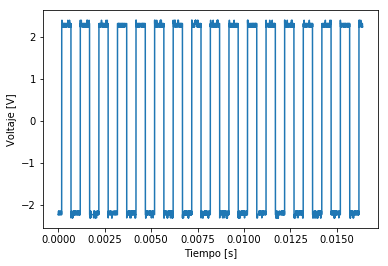

In [64]:
# Cambia a modo RAW (lee todo los puntos)
osci.write(':WAV:POIN:MODE MAX')

# Frena la adquisicion
osci.write(':STOP')

# Adquiere los datos del canal 1 y los devuelve en un array de numpy
data = osci.query_binary_values(':WAV:DATA? CHAN1', datatype='B', container=np.array)

tiempo = np.arange(len(data)) / sample_rate - timeoffset

    #time = np.arange(0, 600.0/50*timescale, timescale/50.0)
data = -(data - yref) * yinc - voltoffset

# Convierte los datos de Unidades digitales a Volts
# data = (240 - data) * voltscale / 25 - (voltoffset + voltscale * 4.6)
 
plt.plot(tiempo, data);
plt.xlabel('Tiempo [s]');
plt.ylabel('Voltaje [V]');

osci.write(':RUN')

In [9]:
# Si vas a repetir la adquisicion muchas veces sin cambiar la escala
# es util definir una funcion que mida y haga las cuentas
def definir_medir(inst):
    # Escala de voltaje
    voltscale = float(inst.query(":CHAN1:SCAL?"))

    # Offset de voltaje
    voltoffset = float(inst.query(":CHAN1:OFFS?"))

    # Escala de tiempo
    timescale = float(inst.query(":TIM:SCAL?"))

    # Offset de tiempo
    timeoffset = float(inst.query(":TIM:OFFS?"))

    # creamos una function auxiliar
    def _medir():
        # Adquiere los datos del canal 1 y los devuelve en un array de numpy
        data = inst.query_binary_values(':WAV:DATA? CHAN1', datatype='B', container=np.array)

        divisions = 12 * 6
        tiempo = timeoffset + np.linspace(-timescale * divisions / 2 , timescale * divisions /2, num=len(data))


        # Convierte los datos de Unidades digitales a Volts
        data = (125 - data) * voltscale / 25 - voltoffset
        return tiempo, data
    
    # Devolvemos la funcion auxiliar que "sabe" la escala
    return _medir

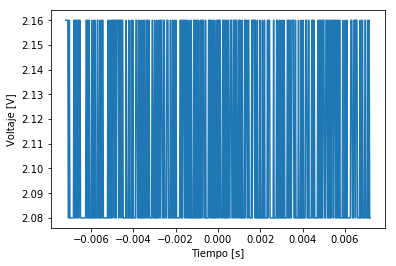

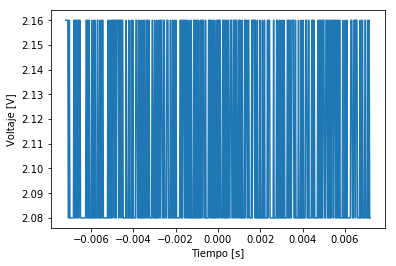

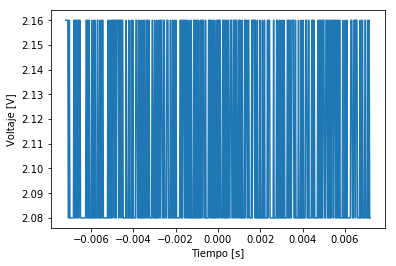

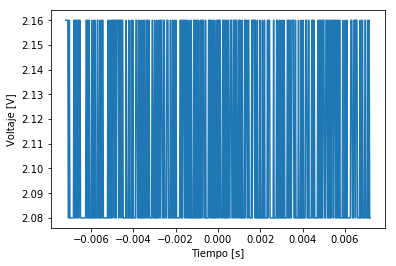

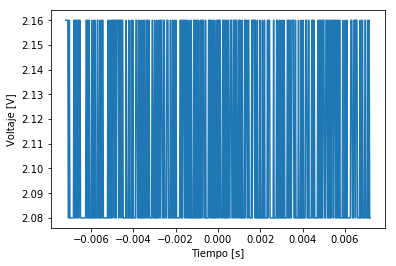

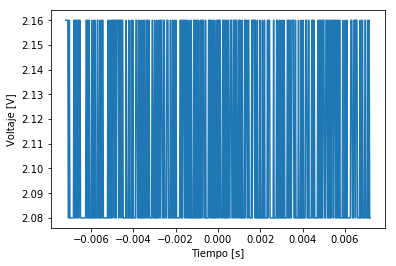

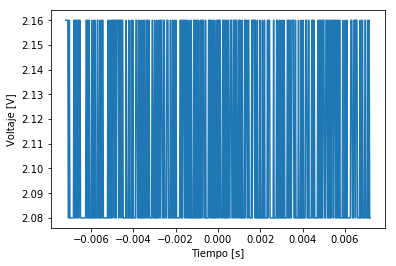

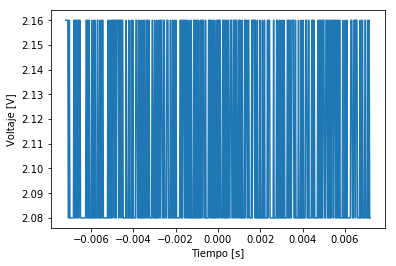

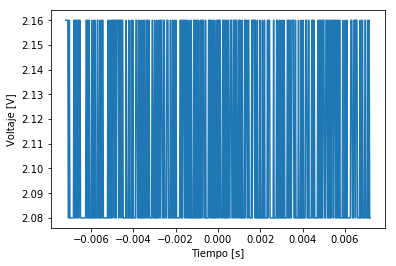

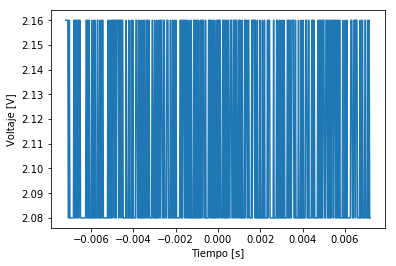

In [10]:
import time

medir = definir_medir(osci)
for n in range(10):
    tiempo, data = medir()
    plt.figure()
    plt.plot(tiempo, data);
    plt.xlabel('Tiempo [s]');
    plt.ylabel('Voltaje [V]');
    time.sleep(1)

In [41]:
osci.close()